In [2]:
import PIL.Image
import numpy as np
from typing import Union
from glob import glob
import pandas as pd
import os
#from treys import Card
from termcolor import colored
from utils import eval_listof_games , debug_listof_games, save_results , load_results
import scipy
from skimage.segmentation import flood, flood_fill
from skimage.morphology import closing, opening, disk

In [3]:
import skimage.io
import matplotlib.pyplot as plt
from skimage.segmentation import flood, flood_fill
from skimage import morphology
from skimage.morphology import closing, opening, disk, square, erosion
from skimage import filters
import cv2 as cv
from skimage.filters import threshold_multiotsu

In [4]:
from helper import *

%load_ext autoreload
%autoreload 2

## Chips

load train images

In [5]:
path_data = 'data/train'
i = 0
file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
images = []

while os.path.exists(file):
    im = skimage.io.imread(file)
    images.append(im)
    i += 1
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
    
cropped_img = []
for image in images:
    _, crop = cropping_routine(image)
    cropped_img.append(crop)

functions

In [6]:
def round_(x,T): ## round function with threshold
    
    n = np.floor(x)
    if (x-n > T): n += 1
    
    return int(n)
    
def n_chips(N,chips_area): ## numbr of chips
    x = chips_area.shape[0]
    y = chips_area.shape[1]
    
    
    x = N/(x*y)/CHIPS_AREA
    
    return round_(x,T=0.3)

In [138]:
def give_color(chips_area,final_mask): ## give color to each pixel
    
    chips_area_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)
    result = np.zeros(chips_area_hsv[:,:,0].shape)
    
    
    chips_area_hsv = np.float64(chips_area_hsv)
    
    x = np.mean(chips_area[0:10,0:10,2])
    black = int(72/(luce-noluce) * (x-noluce) + 38)
    #print(black)
    #black = 84
    result[chips_area_hsv[:,:,2] < black] = 1 #black
    chips_area_hsv[result!=0,:] = float("NAN")
    
    result[chips_area_hsv[:,:,1] < 60] = 2 #white
    chips_area_hsv[result!=0,:] = float("NAN")
    
    result[(chips_area_hsv[:,:,0] < 10) + (chips_area_hsv[:,:,0] >160)] = 3 #red
    chips_area_hsv[result!=0,:] = float("NAN")
    
    result[(chips_area_hsv[:,:,0] > 95) * (chips_area_hsv[:,:,0] < 130)] = 4 #blue
    chips_area_hsv[result!=0,:] = float("NAN")
    
    result[(chips_area_hsv[:,:,0] > 35) * (chips_area_hsv[:,:,0] < 95)] = 5 #green
    
    result = result*final_mask
    
    return result

In [8]:
def predict_chips_area(chips_area): ## predict the pixels in a chips
    
    chips_area_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)
    thresholds = threshold_multiotsu(chips_area_hsv[:,:,2], classes = 2)

    # Using the threshold values, we generate the three regions.
    regions = np.digitize(chips_area_hsv[:,:,2], bins=thresholds)

    thresholds1 = threshold_multiotsu(chips_area_hsv[:,:,0], classes = 2)

    # Using the threshold values, we generate the three regions.
    regions1 = np.digitize(chips_area_hsv[:,:,0], bins=thresholds1)

    tot = (1-regions) + regions1

    tot[tot>0.5] = 1
    #tot = closing(tot,disk(20))
    #display_image(tot)
    #plt.show()
    #tot = erosion(tot,disk(30))
    #display_image(tot)
    #plt.show()
    
    #return tot
    
    nb_px = np.sum(tot == 1)
    
    x = chips_area.shape[0]
    y = chips_area.shape[1]
    
    
    x = nb_px/(x*y)/CHIPS_AREA
    
    return round_(x,T=0.2),tot
    

In [11]:
def find_chips_search_area(image):
    # adapt search area to table size
    row, col = image.shape[:2]
    R, C = int(row/4), int(col/4)
    R_2 = 3*R
    C_2 = 3*C
    # return a crop on the image
    search_area = image[R:R_2, C:C_2]
    return search_area

constant

In [9]:
CHIPS_AREA = 50000/(1750*1760)

In [15]:
idx=10
chips_area = find_chips_search_area(cropped_img[idx])
luce = np.mean(chips_area[0:10,0:10,2])
luce

221.26

In [49]:
idx=3
chips_area = find_chips_search_area(cropped_img[idx])
luce3 = np.mean(chips_area[0:10,0:10,2])
luce3

206.68

In [16]:
idx=12
chips_area = find_chips_search_area(cropped_img[idx])
noluce = np.mean(chips_area[0:10,0:10,2])
noluce

86.66

In [55]:
idx=26
chips_area = find_chips_search_area(cropped_img[idx])
noluce26 = np.mean(chips_area[0:10,0:10,2])
noluce26

168.54

Trails

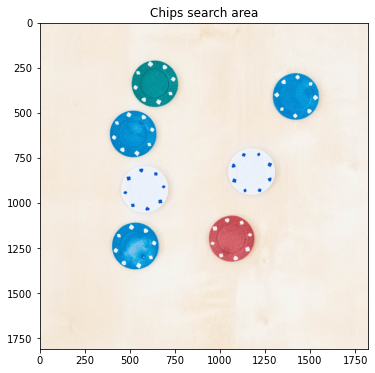

In [92]:
idx = 10
chips_area = find_chips_search_area(cropped_img[idx])
plt.figure(figsize=(6,6))
plt.imshow(chips_area)
plt.title('Chips search area')
plt.show()

single image

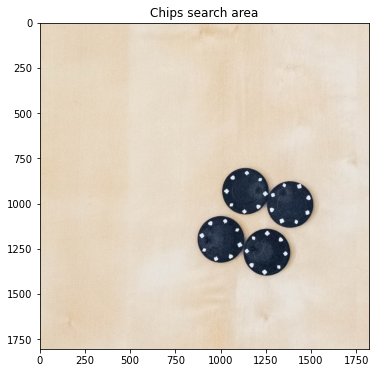

In [101]:
idx = 20
chips_area1 = find_chips_search_area(cropped_img[idx])


plt.figure(figsize=(6,6))
plt.imshow(chips_area1)
plt.title('Chips search area')
plt.show()

pred,final_mask1 = predict_chips_area(chips_area1)
final_mask1 = opening(final_mask1, disk(4))

color1 = give_color(chips_area1,final_mask1)

In [127]:
bianco = np.sum(color1==2) - 0.05*(np.sum(color1==1)+np.sum(color1==4)+np.sum(color1==3)+np.sum(color1==5))

In [128]:
bianco

10206.3

In [129]:
np.sum(color1==2)

19721

In [130]:
n_chips(bianco,final_mask1)

0

In [131]:
n_chips(np.sum(color1==2),final_mask1)

1

all images

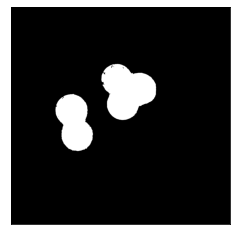

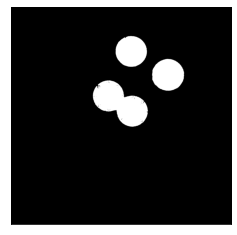

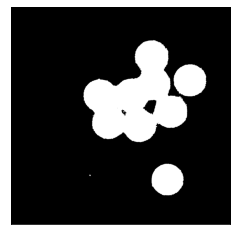

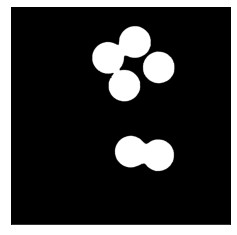

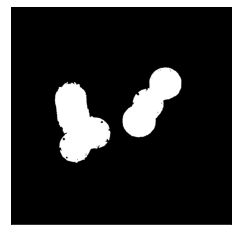

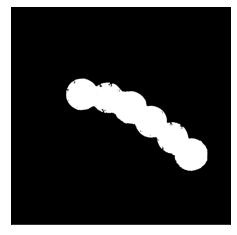

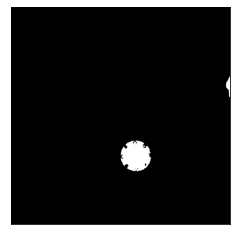

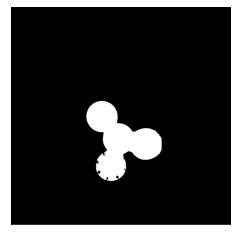

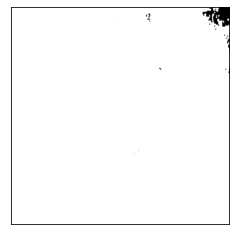

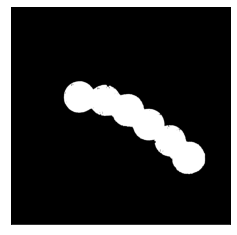

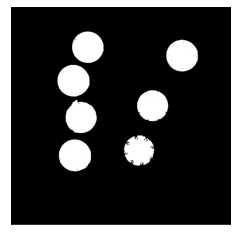

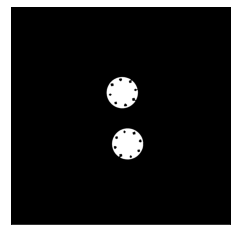

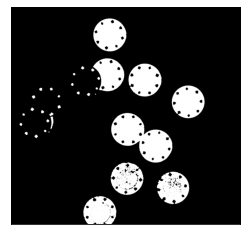

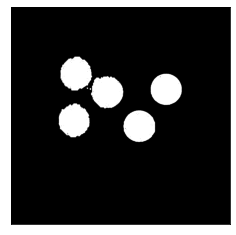

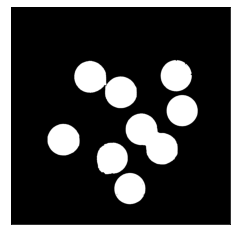

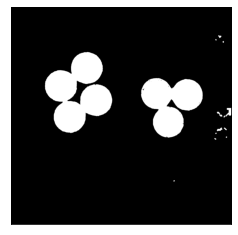

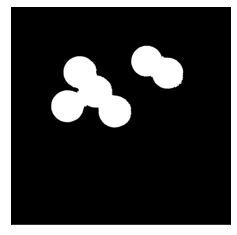

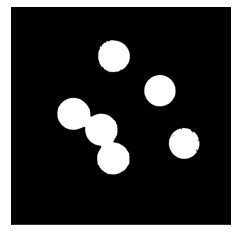

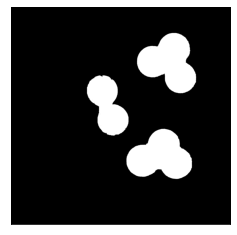

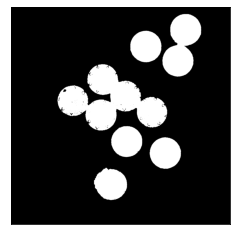

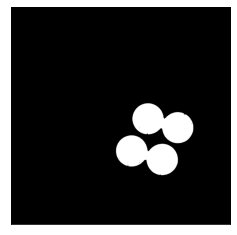

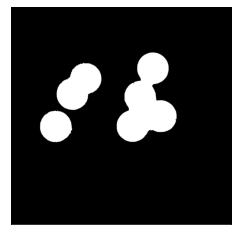

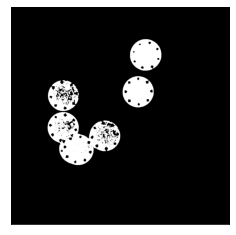

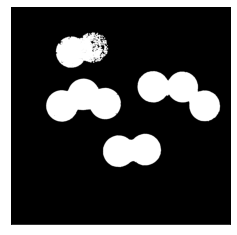

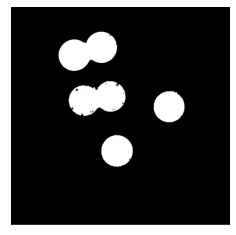

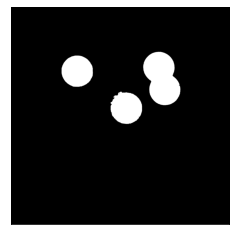

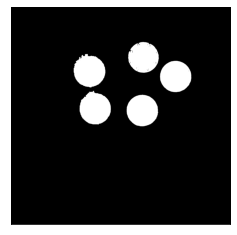

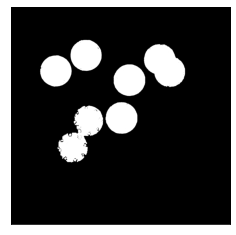

In [33]:
for im in cropped_img:
    chips_area = find_chips_search_area(im)


    pred,final_mask = predict_chips_area(chips_area)
    final_mask = opening(final_mask, disk(4))

    display_image(final_mask)
    plt.show()

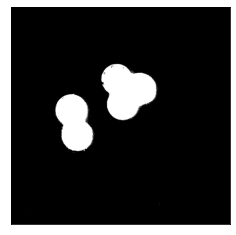

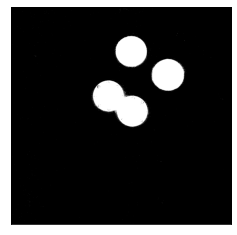

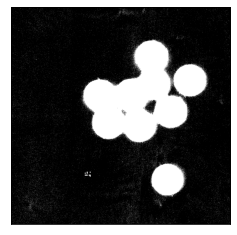

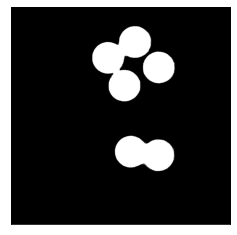

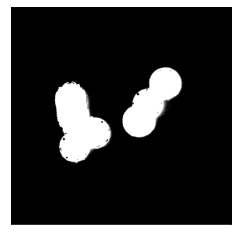

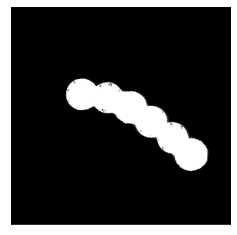

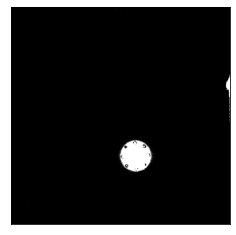

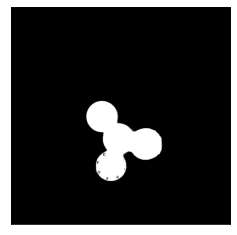

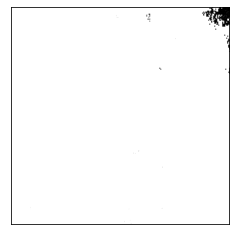

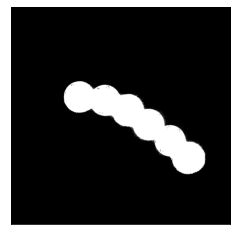

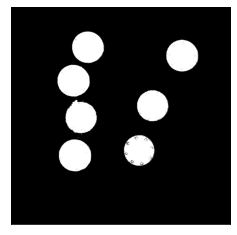

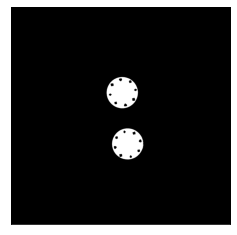

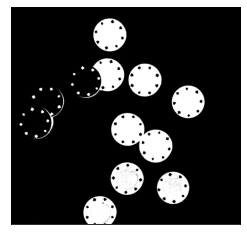

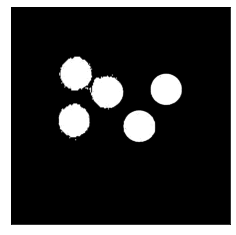

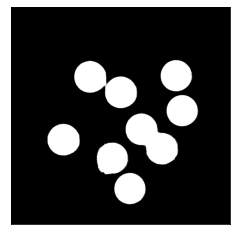

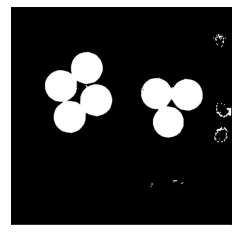

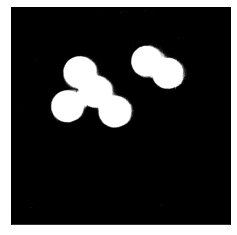

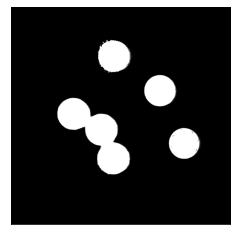

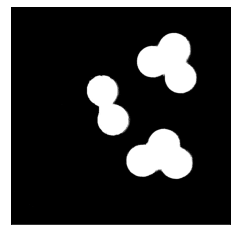

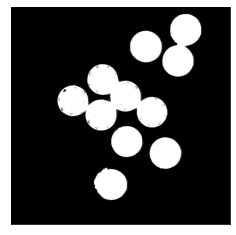

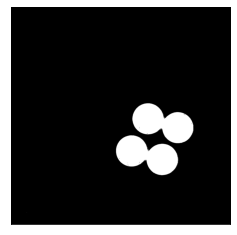

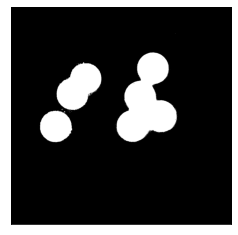

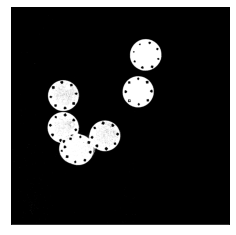

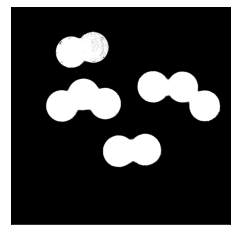

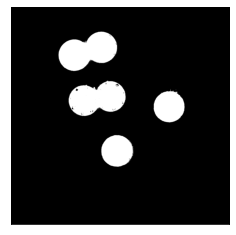

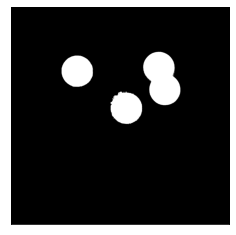

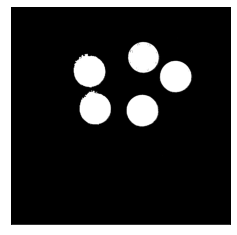

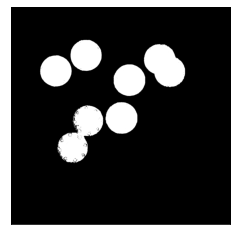

In [31]:
for im in cropped_img:
    chips_area = find_chips_search_area(im)


    pred,final_mask = predict_chips_area(chips_area)
    

    display_image(final_mask)
    plt.show()



In [139]:
idx = 13
black = []
white = []
red = []
green = []
blue = []

for im in cropped_img:
    chips_area = find_chips_search_area(im)


    pred,final_mask = predict_chips_area(chips_area)
    final_mask = opening(final_mask, disk(4))

    #print(pred)

    color = give_color(chips_area,final_mask)
    #print(n_chips(np.sum(color==1),final_mask))
    black.append(n_chips(np.sum(color==1),final_mask))
    bianco = np.sum(color==2) - 0.05*(np.sum(color==1)+np.sum(color==4)+np.sum(color==3)+np.sum(color==5))
    white.append(n_chips(bianco,final_mask))
    red.append(n_chips(np.sum(color==3),final_mask))
    blue.append(n_chips(np.sum(color==4),final_mask))
    green.append(n_chips(np.sum(color==5),final_mask))

In [140]:
green

[1,
 0,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 3,
 3,
 0,
 3,
 2,
 2,
 1,
 1,
 1,
 0]

# Add to helper

In [1]:
from skimage.morphology import closing, opening, disk 



def find_chips_search_area(image):
    # adapt search area to table size
    row, col = image.shape[:2]
    R, C = int(row/4), int(col/4)
    R_2 = 3*R
    C_2 = 3*C
    # return a crop on the image
    search_area = image[R:R_2, C:C_2]
    return search_area


def round_(x,T): ## round function with threshold
    
    n = np.floor(x)
    if (x-n > T): n += 1
    
    return int(n)
    
def n_chips(N,chips_area): ## numbr of chips
    x = chips_area.shape[0]
    y = chips_area.shape[1]
    
    
    x = N/(x*y)/CHIPS_AREA
    
    return round_(x,T=0.3)

def give_color(chips_area,final_mask): ## give color to each pixel
    
    chips_area_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)
    result = np.zeros(chips_area_hsv[:,:,0].shape)
    
    
    chips_area_hsv = np.float64(chips_area_hsv)
    
    x = np.mean(chips_area[0:10,0:10,2])
    black = int(72/(luce-noluce) * (x-noluce) + 38)
    #print(black)
    #black = 84
    result[chips_area_hsv[:,:,2] < black] = 1 #black
    chips_area_hsv[result!=0,:] = float("NAN")
    
    result[chips_area_hsv[:,:,1] < 60] = 2 #white
    chips_area_hsv[result!=0,:] = float("NAN")
    
    result[(chips_area_hsv[:,:,0] < 10) + (chips_area_hsv[:,:,0] >160)] = 3 #red
    chips_area_hsv[result!=0,:] = float("NAN")
    
    result[(chips_area_hsv[:,:,0] > 95) * (chips_area_hsv[:,:,0] < 130)] = 4 #blue
    chips_area_hsv[result!=0,:] = float("NAN")
    
    result[(chips_area_hsv[:,:,0] > 35) * (chips_area_hsv[:,:,0] < 95)] = 5 #green
    
    result = result*final_mask
    
    return result

def predict_chips_area(chips_area): ## predict the pixels in a chips
    
    chips_area_hsv = cv.cvtColor(chips_area, cv.COLOR_RGB2HSV)
    thresholds = threshold_multiotsu(chips_area_hsv[:,:,2], classes = 2)

    # Using the threshold values, we generate the three regions.
    regions = np.digitize(chips_area_hsv[:,:,2], bins=thresholds)

    thresholds1 = threshold_multiotsu(chips_area_hsv[:,:,0], classes = 2)

    # Using the threshold values, we generate the three regions.
    regions1 = np.digitize(chips_area_hsv[:,:,0], bins=thresholds1)

    tot = (1-regions) + regions1

    tot[tot>0.5] = 1
    #tot = closing(tot,disk(20))
    #display_image(tot)
    #plt.show()
    #tot = erosion(tot,disk(30))
    #display_image(tot)
    #plt.show()
    
    #return tot
    
    nb_px = np.sum(tot == 1)
    
    x = chips_area.shape[0]
    y = chips_area.shape[1]
    
    
    x = nb_px/(x*y)/CHIPS_AREA
    
    return round_(x,T=0.2),tot

# Constant

In [7]:
CHIPS_AREA = 50000/(1750*1760)
luce = 221.26
noluce = 86.66

# Function

In [5]:
path_data = 'data/train'
i = 0
file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
images = []

while os.path.exists(file):
    im = skimage.io.imread(file)
    images.append(im)
    i += 1
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg")
    
cropped_img = []
for image in images:
    _, crop = cropping_routine(image)
    cropped_img.append(crop)

In [12]:
prediction = []

for table in cropped_img:
    result = {"CR": 0, "CG": 0, "CB": 0,"CK": 0, "CW": 0}

    # crop table out of image and recuperate scotch markers
    chips_area = find_chips_search_area(table)
    pred,final_mask = predict_chips_area(chips_area)
    final_mask = opening(final_mask, disk(4))

    color = give_color(chips_area,final_mask)


    result["CR"] = n_chips(np.sum(color==3),final_mask) #red 
    result["CG"] = n_chips(np.sum(color==5),final_mask) #green
    result["CB"] = n_chips(np.sum(color==4),final_mask) #blue
    result["CK"] = n_chips(np.sum(color==1),final_mask) #black

    white = np.sum(color==2) - 0.05*(np.sum(color==1)+np.sum(color==4)+np.sum(color==3)+np.sum(color==5))

    result["CW"] = n_chips(white,final_mask) #white
    
    prediction.append(result)

In [13]:
prediction

[{'CR': 1, 'CG': 1, 'CB': 1, 'CK': 1, 'CW': 1},
 {'CR': 2, 'CG': 0, 'CB': 1, 'CK': 0, 'CW': 1},
 {'CR': 0, 'CG': 0, 'CB': 8, 'CK': 1, 'CW': 0},
 {'CR': 0, 'CG': 2, 'CB': 4, 'CK': 0, 'CW': 0},
 {'CR': 3, 'CG': 1, 'CB': 1, 'CK': 0, 'CW': 2},
 {'CR': 2, 'CG': 1, 'CB': 2, 'CK': 1, 'CW': 0},
 {'CR': 1, 'CG': 0, 'CB': 0, 'CK': 0, 'CW': 0},
 {'CR': 1, 'CG': 0, 'CB': 1, 'CK': 2, 'CW': 0},
 {'CR': 0, 'CG': 0, 'CB': 0, 'CK': 0, 'CW': 0},
 {'CR': 2, 'CG': 1, 'CB': 2, 'CK': 1, 'CW': 0},
 {'CR': 1, 'CG': 1, 'CB': 3, 'CK': 0, 'CW': 2},
 {'CR': 0, 'CG': 0, 'CB': 0, 'CK': 2, 'CW': 0},
 {'CR': 3, 'CG': 1, 'CB': 4, 'CK': 0, 'CW': 1},
 {'CR': 0, 'CG': 1, 'CB': 1, 'CK': 0, 'CW': 3},
 {'CR': 0, 'CG': 0, 'CB': 5, 'CK': 3, 'CW': 1},
 {'CR': 3, 'CG': 0, 'CB': 1, 'CK': 4, 'CW': 1},
 {'CR': 0, 'CG': 0, 'CB': 4, 'CK': 0, 'CW': 2},
 {'CR': 1, 'CG': 0, 'CB': 3, 'CK': 1, 'CW': 1},
 {'CR': 0, 'CG': 2, 'CB': 3, 'CK': 0, 'CW': 2},
 {'CR': 5, 'CG': 3, 'CB': 1, 'CK': 0, 'CW': 2},
 {'CR': 0, 'CG': 0, 'CB': 0, 'CK': 4, 'C